<a href="https://colab.research.google.com/github/Palaeoprot/PalaeoProtCourse/blob/main/Burgos_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paleoproteomics Data Analysis Workflow

This notebook is designed for the Paleoproteomics Course (July 7-11, 2025) to help you understand how to process and analyze mass spectrometry data from NovorCloud. Each section is explained to help you understand the purpose of the code and how it works.


## Mount Google Drive
This section mounts your Google Drive to access files stored there. This is necessary because we'll be working with data files from NovorCloud that are stored in Google Drive.


In [1]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting Up the Environment
This section imports all the required libraries for our analysis. We'll use several Python libraries:
- Standard libraries for file handling, regular expressions, and data structures
- NumPy and Pandas for data manipulation
- Matplotlib and Seaborn for data visualization

In [2]:
# Standard library imports
import os
import re
import json
import zipfile
from collections import Counter
import glob
import ast

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## File Type Selection

This cell allows you to select which types of data files from the NovorCloud zip archives will be included in the analysis. By default, all file types (`.psm.csv`, `.peps.txt`, `.denovo.csv`, `.proteins.fasta`, and `parameters.js`) are selected. You can toggle the boolean switches to include or exclude specific file types based on your analytical needs. The selection made here will be used in the next cell (Cell 2) to build the file inventory.

## File Extraction and Organization
This section identifies and extracts data from zip files that were downloaded from NovorCloud. The code:
1. Looks for all zip files in the specified directory
2. Creates an output directory for extracted files if it doesn't exist
3. Extracts two types of files: parameters.js (search settings) and .peps.txt (peptide identifications)
4. Parses the filenames to extract metadata (student, sample, conditions)
5. Creates dataframes to track the extracted files and their metadata
6. Saves this metadata to CSV files for reference

In [24]:
# Cell 1: File Type Selection ---
# Use this cell to select which file types to include in the analysis.

print("Select file types to include in the analysis:")

# Define the available file types and their corresponding keys in file_inventory
available_file_types = {
    '.psm.csv': 'psm_files',
    '.peps.txt': 'peps_files',
    '.denovo.csv': 'denovo_files',
    '.proteins.fasta': 'protein_files',
    'parameters.js': 'param_files'
}

# Create boolean toggles for each file type
include_psm_csv = True #@param {type:"boolean"}
include_peps_txt = False #@param {type:"boolean"}
include_denovo_csv = False #@param {type:"boolean"}
include_proteins_fasta = True #@param {type:"boolean"}
include_parameters_js = True #@param {type:"boolean"}

# Create a list of selected file extensions/names based on the toggles
selected_file_types = []
if include_psm_csv:
    selected_file_types.append('.psm.csv')
if include_peps_txt:
    selected_file_types.append('.peps.txt')
if include_denovo_csv:
    selected_file_types.append('.denovo.csv')
if include_proteins_fasta:
    selected_file_types.append('.proteins.fasta')
if include_parameters_js:
    selected_file_types.append('parameters.js')

# Store the selected file types for the next cell
# We'll store both the extension/name and the inventory key
selected_file_type_info = {
    ext: available_file_types[ext] for ext in selected_file_types
}

print("\nSelected file types for inclusion:")
if selected_file_type_info:
    for file_type, inventory_key in selected_file_type_info.items():
        print(f"- {file_type} (will be stored in '{inventory_key}')")
else:
    print("No file types selected.")

# This variable will be used in Cell 2
globals()['selected_file_type_info_for_inventory'] = selected_file_type_info

print("\nFile type selection complete. Run the next cell to process the selected files.")

Select file types to include in the analysis:

Selected file types for inclusion:
- .psm.csv (will be stored in 'psm_files')
- .proteins.fasta (will be stored in 'protein_files')
- parameters.js (will be stored in 'param_files')

File type selection complete. Run the next cell to process the selected files.


# Cell 2 – Comprehensive NovorCloud Data Extraction and Integration

## Overview
This cell performs a comprehensive extraction and integration of all data types from NovorCloud proteomics search results. It processes multiple file formats generated by different computational approaches and combines them into a unified dataset for comparative analysis.

## What This Cell Does

### 1. File Extraction and Organization
- **Extracts zip files** containing NovorCloud results from your Google Drive
- **Scans for multiple file types**:
 - `.psm.csv` - Peptide-Spectrum Match results (most detailed)
 - `.peps.txt` - Peptide identification summaries
 - `.denovo.csv` - De novo sequencing results (database-independent)
 - `.proteins.fasta` - Protein sequences identified
 - `parameters.js` - Search parameters used for each analysis

### 2. Data Processing Challenges Solved
This cell handles several complex data parsing challenges:

#### PSM Files (.psm.csv)
- **Problem**: Headers start with `#` which pandas treats as comments
- **Solution**: Manually extract headers and skip the comment line
- **Result**: Proper column names like `id`, `peptide`, `score`, `protein`

#### PEPS Files (.peps.txt)
- **Problem**: Different format from PSM files, simpler structure
- **Solution**: Standard CSV parsing with comment handling
- **Result**: Peptide-level data for comparison with PSM results

#### De Novo Files (.denovo.csv)
- **Problem**: Complex multi-line header with metadata, different data structure
- **Solution**: Custom parser that:
 - Extracts search parameters from header comments
 - Finds the data start point after metadata
 - Parses both peptide sequences and confidence scores
- **Result**: Database-independent peptide identifications with per-amino-acid confidence

### 3. Parameter Integration
For each data file, the cell:
- **Locates the corresponding `parameters.js` file** in the same zip archive
- **Extracts search settings** used for that specific analysis
- **Maps parameters to data** so you can see how different settings affect results

### 4. Data Unification Strategy
The cell creates a unified dataset by:
- **Adding source metadata** to track which file and method produced each result
- **Standardizing column names** across different file types
- **Preserving method-specific information** (e.g., de novo confidence scores)
- **Creating consistent sample identifiers** from filenames

## Understanding the Output Data Structure

### Core Columns (Present in All Data Types)
- `peptide` - Amino acid sequence (with modifications in parentheses)
- `score` - Confidence score (higher = more confident)
- `data_source` - Which method produced this result (`PSM`, `PEPS`, or `DENOVO`)
- `sample_id` - Which sample this came from
- `source_file` - Original filename for traceability

### Search Parameter Columns (Prefixed with `search_`)
- `search_enzymeSelection` - Which enzyme was used for digestion simulation
- `search_dbFilenames` - Which protein database was searched
- `search_fixedPtms` - Fixed post-translational modifications
- `search_variablePtms` - Variable post-translational modifications
- `search_precursorErrorTol` - Mass accuracy tolerance for precursor ions
- `search_fragmentErrorTol` - Mass accuracy tolerance for fragment ions

### Method-Specific Columns
#### PSM Data
- `mz` - Mass-to-charge ratio
- `z` - Charge state
- `protein` - Protein identification
- `start`, `length` - Position in protein sequence

#### De Novo Data
- `aaScore` - Per-amino-acid confidence scores
- `denovo_enzyme` - Enzyme setting used for de novo
- `denovo_variableModifications` - Modifications considered
- `mz(data)`, `pepMass(denovo)` - Experimental vs theoretical masses

## Educational Value

### Why We Combine Different File Types
1. **Method Comparison**: See how database search vs de novo sequencing perform on the same data
2. **Parameter Impact**: Understand how changing search settings affects identification rates
3. **Confidence Assessment**: Compare score distributions across different approaches
4. **Completeness Analysis**: Find peptides identified by only one method

### Notes
1. **Computational Trade-offs**:
  - PSM files: Most detailed but require database matches
  - De novo: Database-independent but computationally intensive
  - PEPS: Simplified format for quick analysis

2. **Search Parameter Effects**:
  - How enzyme choice affects peptide identification
  - Impact of mass accuracy tolerances
  - Role of post-translational modification settings

3. **Data Quality Assessment**:
  - Score distributions reveal search stringency
  - Identification rates show method sensitivity
  - Parameter correlation analysis

## Output Files Created
The cell generates several files for different types of analysis:

1. **`combined_comprehensive_results.csv`** - Complete unified dataset
2. **`student_dataset_psm_only.csv`** - PSM data only for focused analysis
3. **`student_dataset_comparison.csv`** - All methods for one sample
4. **`student_dataset_denovo_only.csv`** - De novo results only
5. **`search_parameters_summary.json`** - Parameter settings overview


In [3]:
# ===== Cell 2 =====
# Comprehensive data extraction combining all file types from NovorCloud results

import os
import zipfile
import re
import json
import pandas as pd
from glob import glob

# Define paths
zip_files_dir = '/content/drive/MyDrive/Burgos Proteomics Course/Friday/Uploaded_zip_files'
extracted_dir = '/content/drive/MyDrive/Burgos Proteomics Course/Friday/Extracted_files'
output_csv = '/content/combined_comprehensive_results.csv'

print("Comprehensive NovorCloud data extraction...")
print("="*60)

# Extract all zip files if not already done
zip_files = [f for f in os.listdir(zip_files_dir) if f.endswith('.zip')]
print(f"Found {len(zip_files)} zip files to process")

for zip_file in zip_files:
   zip_path = os.path.join(zip_files_dir, zip_file)
   zip_extract_folder = os.path.join(extracted_dir, os.path.splitext(zip_file)[0])

   if not os.path.exists(zip_extract_folder):
       print(f"Extracting: {zip_file}")
       try:
           with zipfile.ZipFile(zip_path, 'r') as zip_ref:
               os.makedirs(zip_extract_folder, exist_ok=True)
               zip_ref.extractall(zip_extract_folder)
       except Exception as e:
           print(f"  ERROR extracting {zip_file}: {str(e)}")

# Find all relevant files based on selection from Cell 1
file_inventory = {
   'psm_files': [],
   'peps_files': [],
   'denovo_files': [],
   'protein_files': [],
   'param_files': []
}

# Get the selected file types from Cell 1
# Ensure the variable exists, otherwise default to including all types
selected_file_type_info = globals().get('selected_file_type_info_for_inventory', {
    '.psm.csv': 'psm_files',
    '.peps.txt': 'peps_files',
    '.denovo.csv': 'denovo_files',
    '.proteins.fasta': 'protein_files',
    'parameters.js': 'param_files'
})

print("\nBuilding file inventory based on selected types:")
for root, dirs, files in os.walk(extracted_dir):
   for file in files:
       file_path = os.path.join(root, file)
       # Check if the file extension/name is in the selected types
       for selected_ext, inventory_key in selected_file_type_info.items():
           if file.endswith(selected_ext) or file == selected_ext: # Handle exact file names like parameters.js
               file_inventory[inventory_key].append(file_path)
               break # Move to the next file once a match is found


# Report inventory
print(f"\nFile inventory:")
for file_type, files in file_inventory.items():
   print(f"  {file_type}: {len(files)} files")
   # Optionally print file names if there are not too many
   # for file_path in files:
   #     print(f"    {os.path.basename(file_path)}")

# Create mapping from data files to their parameter files
def find_parameter_file(data_file_path):
   """Find the corresponding parameter file for a data file"""
   data_dir = os.path.dirname(data_file_path)
   zip_root = os.path.dirname(data_dir)
   param_path = os.path.join(zip_root, 'parameters.js')
   return param_path if os.path.exists(param_path) else None

def load_parameters(param_path):
   """Load and parse parameters from parameters.js file"""
   try:
       with open(param_path, 'r') as f:
           param_content = f.read()

       match = re.search(r'const parameters = (.+)', param_content)
       if match:
           param_json_str = match.group(1)
           return json.loads(param_json_str)
   except Exception as e:
       print(f"    ERROR loading parameters: {str(e)}")
   return {}

def extract_sample_info(file_path):
   """Extract sample information from file path and name"""
   filename = os.path.basename(file_path)

   # Extract base sample name
   if '23M813_RE1' in filename:
       return '23M813_RE1'
   elif 'RHY_M813' in filename:
       return 'RHY_M813'
   elif 'RHY_M812' in filename:
       return '20220415_RHY_M812'
   # Add more specific sample name rules if needed
   elif '20230419_23M138_S1' in filename:
       return '20230419_23M138_S1'
   elif '20220407_RHY_S813' in filename:
       return '20220407_RHY_S813'
   elif '20220415_RHY_M768' in filename:
       return '20220415_RHY_M768'
   elif '20220415_RHY_M821' in filename:
       return '20220415_RHY_M821'
   elif '20220415_RHY_M822' in filename:
       return '20220415_RHY_M822'
   elif '20220415_RHY_M823' in filename:
       return '20220415_RHY_M823'
   elif '20230419_23M136' in filename:
       return '20230419_23M136'
   else:
       # Extract from filename pattern (e.g., first part before first dot)
       base_name = filename.split('.')[0]
       return base_name

def process_denovo_file(file_path):
   """
   Process a Novor de novo sequencing output file.
   Handles the multi-line header and extracts both metadata and peptide data.
   """
   metadata = {}
   data_rows = []

   with open(file_path, 'r') as f:
       lines = f.readlines()

   # Parse header for metadata
   header_end = 0
   for i, line in enumerate(lines):
       line = line.strip()

       # Skip comment lines that are just decoration
       if line.startswith('#=') or line.startswith('# ') or line == '#':
           continue

       # Extract metadata from header
       if line.startswith('#') and '=' in line:
           # Extract key-value pairs from header
           if 'input file' in line:
               metadata['input_file'] = line.split('=')[1].strip()
           elif 'enzyme' in line:
               metadata['enzyme'] = line.split('=')[1].strip()
           elif 'fragmentation' in line:
               metadata['fragmentation'] = line.split('=')[1].strip()
           elif 'massAnalyzer' in line:
               metadata['massAnalyzer'] = line.split('=')[1].strip()
           elif 'fragmentIonErrorTol' in line:
               metadata['fragmentIonErrorTol'] = line.split('=')[1].strip()
           elif 'precursorErrorTol' in line:
               metadata['precursorErrorTol'] = line.split('=')[1].strip()
           elif 'fixedModifications' in line:
               metadata['fixedModifications'] = line.split('=')[1].strip()
           elif 'variableModifications' in line:
               metadata['variableModifications'] = line.split('=')[1].strip()
           elif 'forbiddenResidues' in line:
               metadata['forbiddenResidues'] = line.split('=')[1].strip()

       # Find the column header line
       elif line.startswith('# id, scanNum'):
           header_end = i + 1
           # Extract column names from this line
           columns = [col.strip().rstrip(',') for col in line[2:].split(',')]
           break

   # Read data rows
   for line in lines[header_end:]:
       line = line.strip()
       if line and not line.startswith('#'):
           # Split by comma, being careful with the last columns that might have commas in them
           parts = line.split(', ')
           if len(parts) >= 10:  # Minimum expected columns
               data_rows.append(parts)

   # Create DataFrame
   if data_rows:
       # The column names from the header
       expected_columns = ['id', 'scanNum', 'RT', 'mz(data)', 'z', 'pepMass(denovo)',
                          'err(data-denovo)', 'ppm(1e6*err/(mz*z))', 'score', 'peptide', 'aaScore']

       df = pd.DataFrame(data_rows, columns=expected_columns[:len(data_rows[0])])

       # Convert numeric columns
       numeric_columns = ['id', 'scanNum', 'RT', 'mz(data)', 'z', 'pepMass(denovo)',
                         'err(data-denovo)', 'ppm(1e6*err/(mz*z))', 'score']

       for col in numeric_columns:
           if col in df.columns:
               df[col] = pd.to_numeric(df[col], errors='coerce')

       # Add metadata as columns
       for key, value in metadata.items():
           df[f'denovo_{key}'] = value

       return df
   else:
       return pd.DataFrame()

# Process PSM files (primary source) if selected
print(f"\nProcessing PSM files...")
psm_dataframes = []
if '.psm.csv' in selected_file_type_info:
    for psm_path in file_inventory['psm_files']:
       filename = os.path.basename(psm_path)
       print(f"  Processing: {filename}")

       try:
           # Read PSM file with proper header handling
           with open(psm_path, 'r') as f:
               first_line = f.readline().strip()

           if first_line.startswith('#'):
               headers = [col.strip() for col in first_line[1:].split(',')]
               psm_df = pd.read_csv(psm_path, skiprows=1, header=None, names=headers)
           else:
               psm_df = pd.read_csv(psm_path)

           if psm_df.empty:
               print(f"    WARNING: Empty file")
               continue

           print(f"    Loaded {len(psm_df)} PSMs")

           # Add file metadata
           psm_df['data_source'] = 'PSM'
           psm_df['source_file'] = filename
           psm_df['sample_id'] = extract_sample_info(psm_path)

           # Load and add parameters
           param_path = find_parameter_file(psm_path)
           if param_path:
               parameters = load_parameters(param_path)
               for key, value in parameters.items():
                   if isinstance(value, (list, dict)):
                       psm_df[f'search_{key}'] = json.dumps(value)
                   else:
                       psm_df[f'search_{key}'] = value
               print(f"    Added {len(parameters)} search parameters")

           psm_dataframes.append(psm_df)

       except Exception as e:
           print(f"    ERROR: {str(e)}")
else:
    print("  .psm.csv files not selected for inclusion.")


# Process PEPS files for comparison if selected
print(f"\nProcessing PEPS files for comparison...")
peps_dataframes = []
if '.peps.txt' in selected_file_type_info:
    for peps_path in file_inventory['peps_files']:
       filename = os.path.basename(peps_path)
       print(f"  Processing: {filename}")

       try:
           peps_df = pd.read_csv(peps_path, comment='#', skip_blank_lines=True, skipinitialspace=True)

           if peps_df.empty:
               print(f"    WARNING: Empty file")
               continue

           print(f"    Loaded {len(peps_df)} peptides")

           # Add file metadata
           peps_df['data_source'] = 'PEPS'
           peps_df['source_file'] = filename
           peps_df['sample_id'] = extract_sample_info(peps_path)

           # Load and add parameters
           param_path = find_parameter_file(peps_path)
           if param_path:
               parameters = load_parameters(param_path)
               for key, value in parameters.items():
                   if isinstance(value, (list, dict)):
                       peps_df[f'search_{key}'] = json.dumps(value)
                   else:
                       peps_df[f'search_{key}'] = value

           peps_dataframes.append(peps_df)

       except Exception as e:
           print(f"    ERROR: {str(e)}")
else:
    print("  .peps.txt files not selected for inclusion.")


# Process De Novo files with corrected parsing if selected
print(f"\nProcessing De Novo files (corrected)...")
denovo_dataframes = []
if '.denovo.csv' in selected_file_type_info:
    for denovo_path in file_inventory['denovo_files']:
       filename = os.path.basename(denovo_path)
       print(f"  Processing: {filename}")

       try:
           denovo_df = process_denovo_file(denovo_path)

           if denovo_df.empty:
               print(f"    WARNING: No data extracted from file")
               continue

           print(f"    Loaded {len(denovo_df)} de novo sequences")

           # Add file metadata
           denovo_df['data_source'] = 'DENOVO'
           denovo_df['source_file'] = filename
           denovo_df['sample_id'] = extract_sample_info(denovo_path)

           # Load and add search parameters (from parameters.js if available)
           param_path = find_parameter_file(denovo_path)
           if param_path:
               parameters = load_parameters(param_path)
               for key, value in parameters.items():
                   if isinstance(value, (list, dict)):
                       denovo_df[f'search_{key}'] = json.dumps(value)
                   else:
                       denovo_df[f'search_{key}'] = value
               print(f"    Added {len(parameters)} search parameters")

           denovo_dataframes.append(denovo_df)

           # Show sample of de novo data
           if 'score' in denovo_df.columns:
               print(f"    Score range: {denovo_df['score'].min():.1f} to {denovo_df['score'].max():.1f}")
           if 'peptide' in denovo_df.columns:
               print(f"    Sample peptide: {denovo_df['peptide'].iloc[0]}")

       except Exception as e:
           print(f"    ERROR: {str(e)}")
else:
    print("  .denovo.csv files not selected for inclusion.")


# Combine all dataframes
print(f"\nCombining all data sources...")
all_dataframes = psm_dataframes + peps_dataframes + denovo_dataframes

if all_dataframes:
   # Get all unique columns
   all_columns = set()
   for df in all_dataframes:
       all_columns.update(df.columns)

   # Ensure all dataframes have all columns
   for df in all_dataframes:
       for col in all_columns:
           if col not in df.columns:
               df[col] = None

   # Combine
   combined_df = pd.concat(all_dataframes, ignore_index=True, sort=False)

   # Save comprehensive dataset
   combined_df.to_csv(output_csv, index=False)

   print(f"\n✅ Comprehensive dataset saved to: {output_csv}")
   print(f"Total rows: {len(combined_df):,}")
   print(f"Total columns: {len(combined_df.columns)}")

   # Summary by data source and sample
   print(f"\nDataset summary:")
   summary = combined_df.groupby(['data_source', 'sample_id']).size().reset_index(name='count')
   for _, row in summary.iterrows():
       print(f"  {row['data_source']} - {row['sample_id']}: {row['count']:,} entries")

   # Search parameter analysis
   search_cols = [col for col in combined_df.columns if col.startswith('search_')]
   print(f"\nSearch parameters captured: {len(search_cols)}")
   for col in sorted(search_cols)[:10]:  # Show first 10
       unique_vals = combined_df[col].nunique()
       print(f"  {col}: {unique_vals} unique values")

   # Show key columns for verification
   key_cols = ['peptide', 'score', 'data_source', 'sample_id', 'source_file']
   available_key_cols = [col for col in key_cols if col in combined_df.columns]

   if available_key_cols:
       print(f"\nSample data:")
       print(combined_df[available_key_cols].head(10))

   # Enhanced educational analysis
   print(f"\n" + "="*60)
   print("EDUCATIONAL ANALYSIS FEATURES")
   print("="*60)

   # 1. Search Parameter Comparison
   print("\n1. SEARCH PARAMETER DIFFERENCES:")
   search_params = ['search_enzymeSelection', 'search_fixedPtms', 'search_variablePtms',
                   'search_precursorErrorTol', 'search_fragmentErrorTol']

   for param in search_params:
       if param in combined_df.columns:
           unique_values = combined_df[param].dropna().unique()
           print(f"  {param.replace('search_', '')}: {len(unique_values)} different settings")
           for i, val in enumerate(unique_values[:3]):  # Show first 3
               count = (combined_df[param] == val).sum()
               print(f"    Setting {i+1}: {str(val)[:50]}... ({count:,} entries)")

   # 2. File Type Performance Comparison
   print(f"\n2. IDENTIFICATION PERFORMANCE BY FILE TYPE:")
   if 'score' in combined_df.columns:
       perf_summary = combined_df.groupby('data_source').agg({
           'score': ['count', 'mean', 'std', 'min', 'max'],
           'peptide': 'nunique'
       }).round(4)

       print(perf_summary)

   # 3. Sample-wise Analysis
   print(f"\n3. SAMPLE COMPARISON:")
   sample_summary = combined_df.groupby(['sample_id', 'data_source']).size().unstack(fill_value=0)
   print(sample_summary)

   # 4. Create filtered datasets for student exercises
   print(f"\n4. CREATING STUDENT EXERCISE DATASETS:")

   # Dataset 1: PSM data only (most comprehensive)
   psm_only = combined_df[combined_df['data_source'] == 'PSM'].copy()
   psm_only.to_csv('/content/student_dataset_psm_only.csv', index=False)
   print(f"  PSM-only dataset: {len(psm_only):,} rows → student_dataset_psm_only.csv")

   # Dataset 2: Comparison dataset (all file types, same sample)
   if len(combined_df['sample_id'].unique()) >= 2:
       sample_1 = combined_df['sample_id'].unique()[0]
       comparison_data = combined_df[combined_df['sample_id'] == sample_1].copy()
       comparison_data.to_csv('/content/student_dataset_comparison.csv', index=False)
       print(f"  Comparison dataset ({sample_1}): {len(comparison_data):,} rows → student_dataset_comparison.csv")

   # Dataset 3: De novo only
   if len(denovo_dataframes) > 0:
       denovo_only = combined_df[combined_df['data_source'] == 'DENOVO'].copy()
       denovo_only.to_csv('/content/student_dataset_denovo_only.csv', index=False)
       print(f"  De novo dataset: {len(denovo_only):,} rows → student_dataset_denovo_only.csv")

   # 5. Create parameter summary for students
   param_summary = {}
   for col in [c for c in combined_df.columns if c.startswith('search_')]:
       unique_vals = combined_df[col].dropna().unique()
       param_summary[col.replace('search_', '')] = {
           'unique_values': len(unique_vals),
           'examples': list(unique_vals[:2])
       }

   # Save parameter summary as JSON for easy reading
   with open('/content/search_parameters_summary.json', 'w') as f:
       json.dump(param_summary, f, indent=2, default=str)
   print(f"  Parameter summary → search_parameters_summary.json")

   print(f"\n" + "="*60)
   print("STUDENT EXPLORATION OPPORTUNITIES:")
   print("="*60)
   print("1. Compare PSM vs PEPS vs De Novo results")
   print("2. Analyze effect of different search parameters")
   print("3. Compare identification rates between samples")
   print("4. Study modification patterns across different searches")
   print("5. Evaluate score distributions by search method")
   print("6. Analyze de novo confidence scores (aaScore column)")
   print("7. Compare database search vs de novo identification overlap")

   # Store the combined dataframe for immediate use
   globals()['comprehensive_df'] = combined_df
   print(f"\n✅ Dataset stored as 'comprehensive_df' variable for immediate analysis")

else:
   print("❌ No data files were successfully processed.")
   print("\nTroubleshooting tips:")
   print("1. Check if zip files are in the correct directory")
   print("2. Verify zip files contain .psm.csv, .peps.txt, or .denovo.csv files")
   print("3. Check file permissions")

Comprehensive NovorCloud data extraction...
Found 5 zip files to process

File inventory:
  psm_files: 16 files
    20230419_23M813_RE1.psm.csv
    20220415_RHY_M813.psm.csv
    20220415_RHY_M813.psm.csv
    20220415_RHY_M813.psm.csv
    20230419_23M813_RE1.psm.csv
    20220415_RHY_M812.psm.csv
    20220415_RHY_M813.psm.csv
    20220415_RHY_M813.psm.csv
    20220415_RHY_M821.psm.csv
    20220415_RHY_M768.psm.csv
    20220407_RHY_S813.psm.csv
    20220415_RHY_M822.psm.csv
    20220415_RHY_M823.psm.csv
    20230419_23M138_S1.psm.csv
    20230419_23M136.psm.csv
    20220407_RHY_S813.psm.csv
  peps_files: 16 files
    20230419_23M813_RE1.peps.txt
    20220415_RHY_M813.peps.txt
    20220415_RHY_M813.peps.txt
    20220415_RHY_M813.peps.txt
    20230419_23M813_RE1.peps.txt
    20220415_RHY_M812.peps.txt
    20220415_RHY_M813.peps.txt
    20220415_RHY_M813.peps.txt
    20220415_RHY_M821.peps.txt
    20220415_RHY_M768.peps.txt
    20220407_RHY_S813.peps.txt
    20220415_RHY_M822.peps.txt
    20

/tmp/ipython-input-3-3622674333.py:330: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_dataframes, ignore_index=True, sort=False)



✅ Comprehensive dataset saved to: /content/combined_comprehensive_results.csv
Total rows: 2,067,900
Total columns: 44

Dataset summary:
  DENOVO - 20220407_RHY_S813: 84,430 entries
  DENOVO - 20220415_RHY_M768: 46,254 entries
  DENOVO - 20220415_RHY_M812: 41,707 entries
  DENOVO - 20220415_RHY_M821: 51,490 entries
  DENOVO - 20220415_RHY_M822: 39,127 entries
  DENOVO - 20220415_RHY_M823: 46,604 entries
  DENOVO - 20230419_23M136: 70,014 entries
  DENOVO - 20230419_23M138_S1: 115,251 entries
  DENOVO - 23M813_RE1: 216,176 entries
  DENOVO - RHY_M813: 252,070 entries
  PEPS - 20220407_RHY_S813: 82,855 entries
  PEPS - 20220415_RHY_M768: 46,112 entries
  PEPS - 20220415_RHY_M812: 40,482 entries
  PEPS - 20220415_RHY_M821: 51,436 entries
  PEPS - 20220415_RHY_M822: 37,178 entries
  PEPS - 20220415_RHY_M823: 46,391 entries
  PEPS - 20230419_23M136: 63,558 entries
  PEPS - 20230419_23M138_S1: 114,513 entries
  PEPS - 23M813_RE1: 213,226 entries
  PEPS - RHY_M813: 251,247 entries
  PSM - 202

## Enriching the Data
This section loads the combined data file and enhances it by processing the various parameters from the search. The code:
1. Loads the previously combined peptide and parameter data
2. Processes parameter columns that contain complex data (like lists of PTMs)
3. Creates boolean columns for each type of parameter (e.g., each enzyme type, each fixed or variable PTM)
4. Extracts raw filename and database filename information
5. Parses actual sample types based on raw filenames
6. Provides detailed information about the updated dataframe
7. Saves the enriched dataframe to a new CSV file


This enrichment makes the data easier to analyze because it transforms complex nested data into simple boolean columns.



In [4]:
# ===== Cell 3 =====
# Enhanced Gene Mapping and Sample Information Integration
# This cell enriches the comprehensive_df from Cell 2 with:
# 1. Gene name mapping from protein accession IDs
# 2. Sample metadata mapping from raw filenames
# 3. Parameter parsing and boolean column creation
# 4. PTM stripping for cleaner peptide analysis

import pandas as pd
import json
import ast
import re
from collections import Counter

print("Enhanced Gene Mapping and Sample Information Integration")
print("=" * 60)

# Step 1: Load the comprehensive dataset from Cell 2
try:
    # Use the dataframe created in Cell 2
    df = comprehensive_df.copy()
    print(f"✅ Loaded comprehensive dataset: {len(df):,} rows, {len(df.columns)} columns")
except NameError:
    # Fallback to loading from CSV if variable not available
    try:
        df = pd.read_csv('/content/combined_comprehensive_results.csv')
        print(f"✅ Loaded from CSV: {len(df):,} rows, {len(df.columns)} columns")
    except FileNotFoundError:
        print("❌ No data found. Please run Cell 2 first to generate the comprehensive dataset.")
        df = pd.DataFrame()

if df.empty:
    print("Cannot proceed without data. Please run Cell 2 first.")
else:
    # Step 2: Load protein mapping data (Entry → GeneID)
    print("\nStep 2: Loading protein mapping data...")
    try:
        # Try to read from uploaded files first
        protein_mapping_df = pd.read_csv('Sample_and_protein_data  protein_list.csv')
        print(f"✅ Loaded protein mapping from uploaded file: {len(protein_mapping_df)} entries")
    except FileNotFoundError:
        # Fallback to Google Sheets URL
        try:
            protein_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQvmN0mx-DLJ_-Mx6IuEJi8PMpoo0NQC7MxkpCMBb9n4I7ZT_Yn8rpKLgGLhJae1n_sIY9Rj1SQ7M_V/pub?gid=1778937680&single=true&output=csv'
            protein_mapping_df = pd.read_csv(protein_url)
            print(f"✅ Loaded protein mapping from Google Sheets: {len(protein_mapping_df)} entries")
        except Exception as e:
            print(f"❌ Error loading protein mapping: {e}")
            protein_mapping_df = pd.DataFrame(columns=['Entry', 'GeneID'])

    # Step 3: Load sample mapping data (raw filename → sample metadata)
    print("\nStep 3: Loading sample metadata...")
    try:
        # Try to read from uploaded files first
        sample_list_df = pd.read_csv('Sample_and_protein_data  sample_list.csv')
        print(f"✅ Loaded sample list from uploaded file: {len(sample_list_df)} entries")
    except FileNotFoundError:
        # Fallback to Google Sheets URL
        try:
            sample_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQvmN0mx-DLJ_-Mx6IuEJi8PMpoo0NQC7MxkpCMBb9n4I7ZT_Yn8rpKLgGLhJae1n_sIY9Rj1SQ7M_V/pub?gid=254673331&single=true&output=csv'
            sample_list_df = pd.read_csv(sample_url)
            print(f"✅ Loaded sample list from Google Sheets: {len(sample_list_df)} entries")
        except Exception as e:
            print(f"❌ Error loading sample list: {e}")
            sample_list_df = pd.DataFrame(columns=['raw data file', 'sample', 'fraction', 'instrument', 'institute', 'Analyst'])

    # Step 4: Create mapping dictionaries
    print("\nStep 4: Creating mapping dictionaries...")

    # Protein accession to gene name mapping
    if not protein_mapping_df.empty and 'Entry' in protein_mapping_df.columns and 'GeneID' in protein_mapping_df.columns:
        accession_to_gene = dict(zip(protein_mapping_df['Entry'], protein_mapping_df['GeneID']))
        print(f"✅ Created protein mapping dictionary: {len(accession_to_gene)} entries")
    else:
        accession_to_gene = {}
        print("⚠️ No protein mapping data available")

    # Sample filename to metadata mapping
    if not sample_list_df.empty and 'raw data file' in sample_list_df.columns:
        sample_mapping = dict(zip(
            sample_list_df['raw data file'],
            sample_list_df[['sample', 'fraction', 'instrument', 'institute', 'Analyst']].to_dict('records')
        ))
        print(f"✅ Created sample mapping dictionary: {len(sample_mapping)} entries")
    else:
        sample_mapping = {}
        print("⚠️ No sample mapping data available")

    # Step 5: Extract accession IDs from protein descriptions
    print("\nStep 5: Extracting protein accession IDs...")

    def extract_accession_id(protein_desc):
        """Extract accession ID from protein description (UniProt format)"""
        if isinstance(protein_desc, str):
            # Handle UniProt format: sp|P02452|CO1A1_HUMAN or tr|A0A3Q1234|...
            if '|' in protein_desc:
                parts = protein_desc.split('|')
                if len(parts) >= 2:
                    return parts[1]  # Return the accession ID part
            # Handle cases where it's just the accession ID
            elif protein_desc.strip():
                return protein_desc.strip()
        return None

    if 'protein' in df.columns:
        df['accession_id'] = df['protein'].apply(extract_accession_id)
        valid_accessions = df['accession_id'].notna().sum()
        print(f"✅ Extracted {valid_accessions:,} valid accession IDs from {len(df):,} entries")
    else:
        df['accession_id'] = None
        print("⚠️ No 'protein' column found for accession ID extraction")

    # Step 6: Map gene names
    print("\nStep 6: Mapping gene names...")

    if accession_to_gene and 'accession_id' in df.columns:
        df['gene_name'] = df['accession_id'].map(accession_to_gene).fillna("Unknown")
        mapped_genes = (df['gene_name'] != "Unknown").sum()
        print(f"✅ Successfully mapped {mapped_genes:,} gene names ({mapped_genes/len(df)*100:.1f}%)")

        # Show top mapped genes
        top_genes = df[df['gene_name'] != "Unknown"]['gene_name'].value_counts().head(5)
        print("Top 5 mapped genes:")
        for gene, count in top_genes.items():
            print(f"  {gene}: {count} entries")
    else:
        df['gene_name'] = "Unknown"
        print("⚠️ Gene mapping skipped - no mapping data or accession IDs available")

    # Step 7: Extract and map sample metadata
    print("\nStep 7: Mapping sample metadata...")

    def map_sample_metadata(source_file):
        """Map source filename to sample metadata"""
        default_metadata = {'sample': 'unknown', 'fraction': 'unknown', 'instrument': 'unknown',
                           'institute': 'unknown', 'analyst': 'unknown'}

        if pd.isna(source_file):
            return default_metadata

        # Try exact match first
        if source_file in sample_mapping:
            metadata = sample_mapping[source_file].copy()
            # Standardize the analyst key (handle both 'Analyst' and 'analyst')
            if 'Analyst' in metadata:
                metadata['analyst'] = metadata['Analyst']
            return {**default_metadata, **metadata}

        # Try without file extension
        base_name = str(source_file).split('.')[0]
        if base_name in sample_mapping:
            metadata = sample_mapping[base_name].copy()
            if 'Analyst' in metadata:
                metadata['analyst'] = metadata['Analyst']
            return {**default_metadata, **metadata}

        # Try partial matching
        for mapped_file in sample_mapping.keys():
            if mapped_file in str(source_file) or str(source_file) in mapped_file:
                metadata = sample_mapping[mapped_file].copy()
                if 'Analyst' in metadata:
                    metadata['analyst'] = metadata['Analyst']
                return {**default_metadata, **metadata}

        # Return defaults with base name as sample
        return {**default_metadata, 'sample': base_name}

    if 'source_file' in df.columns and sample_mapping:
        metadata_series = df['source_file'].apply(map_sample_metadata)

        # Create metadata columns
        df['sample'] = metadata_series.apply(lambda x: x['sample'])
        df['fraction'] = metadata_series.apply(lambda x: x['fraction'])
        df['instrument'] = metadata_series.apply(lambda x: x['instrument'])
        df['institute'] = metadata_series.apply(lambda x: x['institute'])
        df['analyst'] = metadata_series.apply(lambda x: x['analyst'])

        mapped_count = sum(1 for x in metadata_series if x['sample'] != 'unknown')
        print(f"✅ Mapped sample metadata for {mapped_count:,}/{len(df):,} entries ({mapped_count/len(df)*100:.1f}%)")

        # Show sample distribution
        print("Sample distribution:")
        for sample, count in df['sample'].value_counts().head(5).items():
            print(f"  {sample}: {count} entries")
    else:
        # Create default columns
        df['sample'] = 'unknown'
        df['fraction'] = 'unknown'
        df['instrument'] = 'unknown'
        df['institute'] = 'unknown'
        df['analyst'] = 'unknown'
        print("⚠️ Sample metadata mapping skipped - no mapping data or source_file column")

    # Step 8: Strip PTMs from peptide sequences for cleaner analysis
    print("\nStep 8: Stripping PTMs from peptide sequences...")

    def strip_ptms(peptide_sequence):
        """Remove PTM annotations (text in parentheses) from peptide sequences"""
        if isinstance(peptide_sequence, str):
            return re.sub(r'\([^)]+\)', '', peptide_sequence)
        return peptide_sequence

    if 'peptide' in df.columns:
        df['stripped_peptide'] = df['peptide'].apply(strip_ptms)
        unique_stripped = df['stripped_peptide'].nunique()
        unique_original = df['peptide'].nunique()
        print(f"✅ Created stripped peptide sequences: {unique_stripped:,} unique (vs {unique_original:,} with PTMs)")
    else:
        print("⚠️ No 'peptide' column found for PTM stripping")

    # Step 9: Extract gene names from protein descriptions
    print("\nStep 9: Extracting gene names from protein descriptions...")

    def extract_gene_name_from_protein(protein_desc):
        """Extract standardized gene name from protein description"""
        if pd.isna(protein_desc) or protein_desc == '':
            return None

        protein_str = str(protein_desc).strip()

        # Method 1: UniProt format - extract from protein name part
        uniprot_pattern = r'(?:sp|tr)\|[A-Z0-9]+\|([A-Z0-9]+)_'
        uniprot_match = re.search(uniprot_pattern, protein_str)
        if uniprot_match:
            gene_candidate = uniprot_match.group(1)
            gene_candidate = re.sub(r'_HUMAN|_MOUSE|_BOVIN|_PIG|_SHEEP', '', gene_candidate)
            return gene_candidate.upper()

        # Method 2: Collagen patterns - most important for paleoproteomics
        collagen_pattern = r'collagen\s+alpha-?(\d+)\s*\(([IVX]+)\)'
        collagen_match = re.search(collagen_pattern, protein_str, re.IGNORECASE)
        if collagen_match:
            alpha_num = collagen_match.group(1)
            col_type = collagen_match.group(2)

            # Convert Roman numerals to numbers
            roman_to_num = {'I': '1', 'II': '2', 'III': '3', 'IV': '4', 'V': '5',
                           'VI': '6', 'VII': '7', 'VIII': '8', 'IX': '9', 'X': '10',
                           'XI': '11', 'XII': '12', 'XIII': '13', 'XIV': '14', 'XV': '15'}

            col_num = roman_to_num.get(col_type, col_type)
            return f"COL{col_num}A{alpha_num}"

        # Method 3: Common proteins
        if re.search(r'titin', protein_str, re.IGNORECASE):
            return 'TTN'
        if re.search(r'fibronectin', protein_str, re.IGNORECASE):
            return 'FN1'
        if re.search(r'elastin', protein_str, re.IGNORECASE):
            return 'ELN'
        if re.search(r'keratin', protein_str, re.IGNORECASE):
            return 'KRT'
        if re.search(r'myosin', protein_str, re.IGNORECASE):
            myosin_match = re.search(r'myosin[,\s]+heavy\s+chain\s+(\d+)', protein_str, re.IGNORECASE)
            if myosin_match:
                return f'MYH{myosin_match.group(1)}'
            return 'MYH'
        if re.search(r'actin', protein_str, re.IGNORECASE):
            return 'ACTA'
        if re.search(r'albumin', protein_str, re.IGNORECASE):
            return 'ALB'
        if re.search(r'hemoglobin', protein_str, re.IGNORECASE):
            if re.search(r'alpha', protein_str, re.IGNORECASE):
                return 'HBA'
            elif re.search(r'beta', protein_str, re.IGNORECASE):
                return 'HBB'
            return 'HB'

        # Method 4: Extract gene-like patterns
        gene_pattern = r'\b([A-Z]{2,6}\d*[A-Z]*\d*)\b'
        gene_matches = re.findall(gene_pattern, protein_str)

        if gene_matches:
            filtered_matches = []
            for match in gene_matches:
                if re.match(r'^[A-Z]{2}_\d+', match):  # Skip RefSeq patterns
                    continue
                if len(match) > 10 or match in ['HUMAN', 'MOUSE', 'BOVIN']:
                    continue
                filtered_matches.append(match)

            if filtered_matches:
                return filtered_matches[0].upper()

        return None

    # Extract gene names from protein descriptions
    if 'protein' in df.columns and 'extracted_gene_name' not in df.columns:
        df['extracted_gene_name'] = df['protein'].apply(extract_gene_name_from_protein)

        # Report extraction success
        total_proteins = df['protein'].notna().sum()
        extracted_genes = df['extracted_gene_name'].notna().sum()

        if extracted_genes > 0:
            print(f"✅ Extracted gene names from {extracted_genes:,}/{total_proteins:,} proteins ({extracted_genes/total_proteins*100:.1f}%)")

            # Show top extracted genes
            top_extracted_genes = df['extracted_gene_name'].value_counts().head(5)
            print("Top 5 extracted genes:")
            for gene, count in top_extracted_genes.items():
                print(f"  {gene}: {count} entries")
        else:
            print("⚠️ No gene names could be extracted from protein descriptions")
    elif 'extracted_gene_name' in df.columns:
        print("✅ Extracted gene name column already exists")
    else:
        print("⚠️ No protein column found for gene name extraction")

    # Step 10: Standardize gene names to fix inconsistencies
    print("\nStep 10: Standardizing gene names...")

    def standardize_gene_name(gene_name):
        """Standardize gene names to fix common inconsistencies"""
        if pd.isna(gene_name) or gene_name == "Unknown":
            return gene_name

        gene_str = str(gene_name).upper().strip()

        # Fix common collagen naming inconsistencies
        # CO1A1 -> COL1A1, CO1A2 -> COL1A2, etc.
        gene_str = re.sub(r'^CO(\d+A\d+)', r'COL\1', gene_str)

        # Fix other common patterns
        gene_str = re.sub(r'[_\s]+$', '', gene_str)  # Remove trailing underscores/spaces

        # Fix common protein name variations
        standardizations = {
            'TITIN': 'TTN',
            'FIBRONECTIN': 'FN1',
            'ELASTIN': 'ELN',
            'ALBUMIN': 'ALB',
            'KERATIN': 'KRT',
            'MYOSIN': 'MYH',
            'ACTIN': 'ACTA'
        }

        if gene_str in standardizations:
            gene_str = standardizations[gene_str]

        return gene_str

    # Standardize all gene name columns
    gene_columns_to_standardize = ['gene_name', 'extracted_gene_name']

    for col in gene_columns_to_standardize:
        if col in df.columns:
            original_unique = df[col].nunique()
            df[col] = df[col].apply(standardize_gene_name)
            new_unique = df[col].nunique()
            merged_count = original_unique - new_unique

            if merged_count > 0:
                print(f"✅ Standardized {col}: merged {merged_count} duplicate gene names")
            else:
                print(f"✅ {col} already standardized")

    # Step 11: Create consolidated gene_name column (updated with standardization)
    print("\nStep 11: Creating consolidated gene name column...")

    # Combine mapped gene names with extracted gene names for best coverage
    if 'gene_name' in df.columns and 'extracted_gene_name' in df.columns:
        # Use mapped gene names where available, fall back to extracted ones
        def consolidate_gene_names(row):
            if pd.notna(row['gene_name']) and row['gene_name'] != "Unknown":
                return row['gene_name']
            elif pd.notna(row['extracted_gene_name']):
                return row['extracted_gene_name']
            else:
                return "Unknown"

        df['consolidated_gene_name'] = df.apply(consolidate_gene_names, axis=1)

        # Apply final standardization to consolidated column
        df['consolidated_gene_name'] = df['consolidated_gene_name'].apply(standardize_gene_name)

        # Report consolidation results
        mapped_only = ((df['gene_name'] != "Unknown") & df['gene_name'].notna() & df['extracted_gene_name'].isna()).sum()
        extracted_only = (df['extracted_gene_name'].notna() & ((df['gene_name'] == "Unknown") | df['gene_name'].isna())).sum()
        both_available = (df['extracted_gene_name'].notna() & (df['gene_name'] != "Unknown") & df['gene_name'].notna()).sum()
        total_with_genes = (df['consolidated_gene_name'] != "Unknown").sum()

        print(f"✅ Created consolidated gene name column:")
        print(f"   From mapping only: {mapped_only:,} entries")
        print(f"   From extraction only: {extracted_only:,} entries")
        print(f"   Both sources available: {both_available:,} entries")
        print(f"   Total with gene names: {total_with_genes:,}/{len(df):,} ({total_with_genes/len(df)*100:.1f}%)")

        # Show top genes after consolidation and standardization
        clean_genes = df[df['consolidated_gene_name'] != "Unknown"]['consolidated_gene_name']
        if len(clean_genes) > 0:
            top_genes_final = clean_genes.value_counts().head(10)
            print(f"   Top 10 genes after standardization:")
            for gene, count in top_genes_final.items():
                print(f"     {gene}: {count:,} entries")

    elif 'extracted_gene_name' in df.columns:
        # Use extracted gene names as the consolidated column
        df['consolidated_gene_name'] = df['extracted_gene_name'].apply(standardize_gene_name).fillna("Unknown")
        total_with_genes = (df['consolidated_gene_name'] != "Unknown").sum()
        print(f"✅ Using extracted gene names as consolidated column: {total_with_genes:,} entries")

    elif 'gene_name' in df.columns:
        # Use existing gene names as the consolidated column
        df['consolidated_gene_name'] = df['gene_name'].apply(standardize_gene_name).fillna("Unknown")
        total_with_genes = (df['consolidated_gene_name'] != "Unknown").sum()
        print(f"✅ Using existing gene names as consolidated column: {total_with_genes:,} entries")

    else:
        df['consolidated_gene_name'] = "Unknown"
        print("⚠️ No gene name sources available")

    # Step 12: Parse and expand search parameters (for PSM/PEPS data)
    print("\nStep 12: Processing search parameters...")

    search_param_cols = [col for col in df.columns if col.startswith('search_')]
    processed_params = 0

    for param_col in search_param_cols:
        if param_col in df.columns:
            try:
                # Try to parse JSON-like parameters
                unique_values = df[param_col].dropna().unique()

                # If values look like lists/arrays, create boolean columns
                if any(str(val).startswith('[') for val in unique_values):
                    for idx, val in enumerate(unique_values):
                        if str(val).startswith('['):
                            try:
                                parsed_list = json.loads(str(val).replace("'", '"'))
                                if isinstance(parsed_list, list):
                                    for item in parsed_list:
                                        safe_item = str(item).replace(' ', '_').replace('(', '').replace(')', '')
                                        bool_col = f"{param_col}_{safe_item}"
                                        df[bool_col] = df[param_col].apply(
                                            lambda x: str(item) in str(x) if pd.notna(x) else False
                                        )
                                processed_params += 1
                            except:
                                continue
            except Exception as e:
                continue

    if processed_params > 0:
        print(f"✅ Processed {processed_params} search parameter columns")
    else:
        print("⚠️ No search parameters found to process")

    # Step 10: Final dataset summary
    print(f"\n" + "=" * 60)
    print("ENHANCED DATASET SUMMARY")
    print("=" * 60)
    print(f"Total entries: {len(df):,}")
    print(f"Total columns: {len(df.columns)}")

    if 'data_source' in df.columns:
        print(f"\nData source breakdown:")
        for source, count in df['data_source'].value_counts().items():
            print(f"  {source}: {count:,} entries")

    if 'consolidated_gene_name' in df.columns:
        mapped_genes = (df['consolidated_gene_name'] != "Unknown").sum()
        print(f"\nGene mapping: {mapped_genes:,}/{len(df):,} entries mapped ({mapped_genes/len(df)*100:.1f}%)")

    if 'sample' in df.columns:
        mapped_samples = (df['sample'] != 'unknown').sum()
        print(f"Sample mapping: {mapped_samples:,}/{len(df):,} entries mapped ({mapped_samples/len(df)*100:.1f}%)")

    # Step 11: Save enhanced dataset
    output_file = '/content/enhanced_comprehensive_dataset.csv'
    df.to_csv(output_file, index=False)
    print(f"\n✅ Enhanced dataset saved to: {output_file}")

    # Store enhanced dataframe for subsequent analysis
    globals()['enhanced_df'] = df
    print(f"✅ Dataset stored as 'enhanced_df' variable for immediate analysis")

    # Show sample of enhanced data
    print(f"\nSample of enhanced data:")
    key_cols = ['peptide', 'stripped_peptide', 'consolidated_gene_name', 'sample', 'data_source', 'score']
    available_cols = [col for col in key_cols if col in df.columns]
    if available_cols:
        print(df[available_cols].head(3).to_string(index=False))

print(f"\n" + "=" * 60)
print("Ready for analysis! Use 'enhanced_df' for further exploration.")
print("=" * 60)

Enhanced Gene Mapping and Sample Information Integration
✅ Loaded comprehensive dataset: 2,067,900 rows, 44 columns

Step 2: Loading protein mapping data...
✅ Loaded protein mapping from Google Sheets: 757 entries

Step 3: Loading sample metadata...
✅ Loaded sample list from Google Sheets: 37 entries

Step 4: Creating mapping dictionaries...
✅ Created protein mapping dictionary: 709 entries
✅ Created sample mapping dictionary: 37 entries

Step 5: Extracting protein accession IDs...
✅ Extracted 378,872 valid accession IDs from 2,067,900 entries

Step 6: Mapping gene names...
✅ Successfully mapped 182,299 gene names (8.8%)
Top 5 mapped genes:
  COL1A2: 68631 entries
  COL1A1: 62224 entries
  COL3A1: 8377 entries
  col2a1: 2697 entries
  CHAD: 2417 entries

Step 7: Mapping sample metadata...
✅ Mapped sample metadata for 2,067,900/2,067,900 entries (100.0%)
Sample distribution:
  20220415_RHY_M813: 569435 entries
  20230419_23M813_RE1: 465778 entries
  20230419_23M138_S1: 243497 entries
  

## Graphic Visualisation

CLEAN PROTEIN ANALYSIS VISUALIZATION
(Excluding missing and unknown entries)
✅ Using dataframe: enhanced_df
   Total rows: 2,067,900
   Available columns include: 79 total
   ✅ Has consolidated gene names
   ✅ Has protein descriptions
Preparing clean datasets...
Creating clean visualizations...


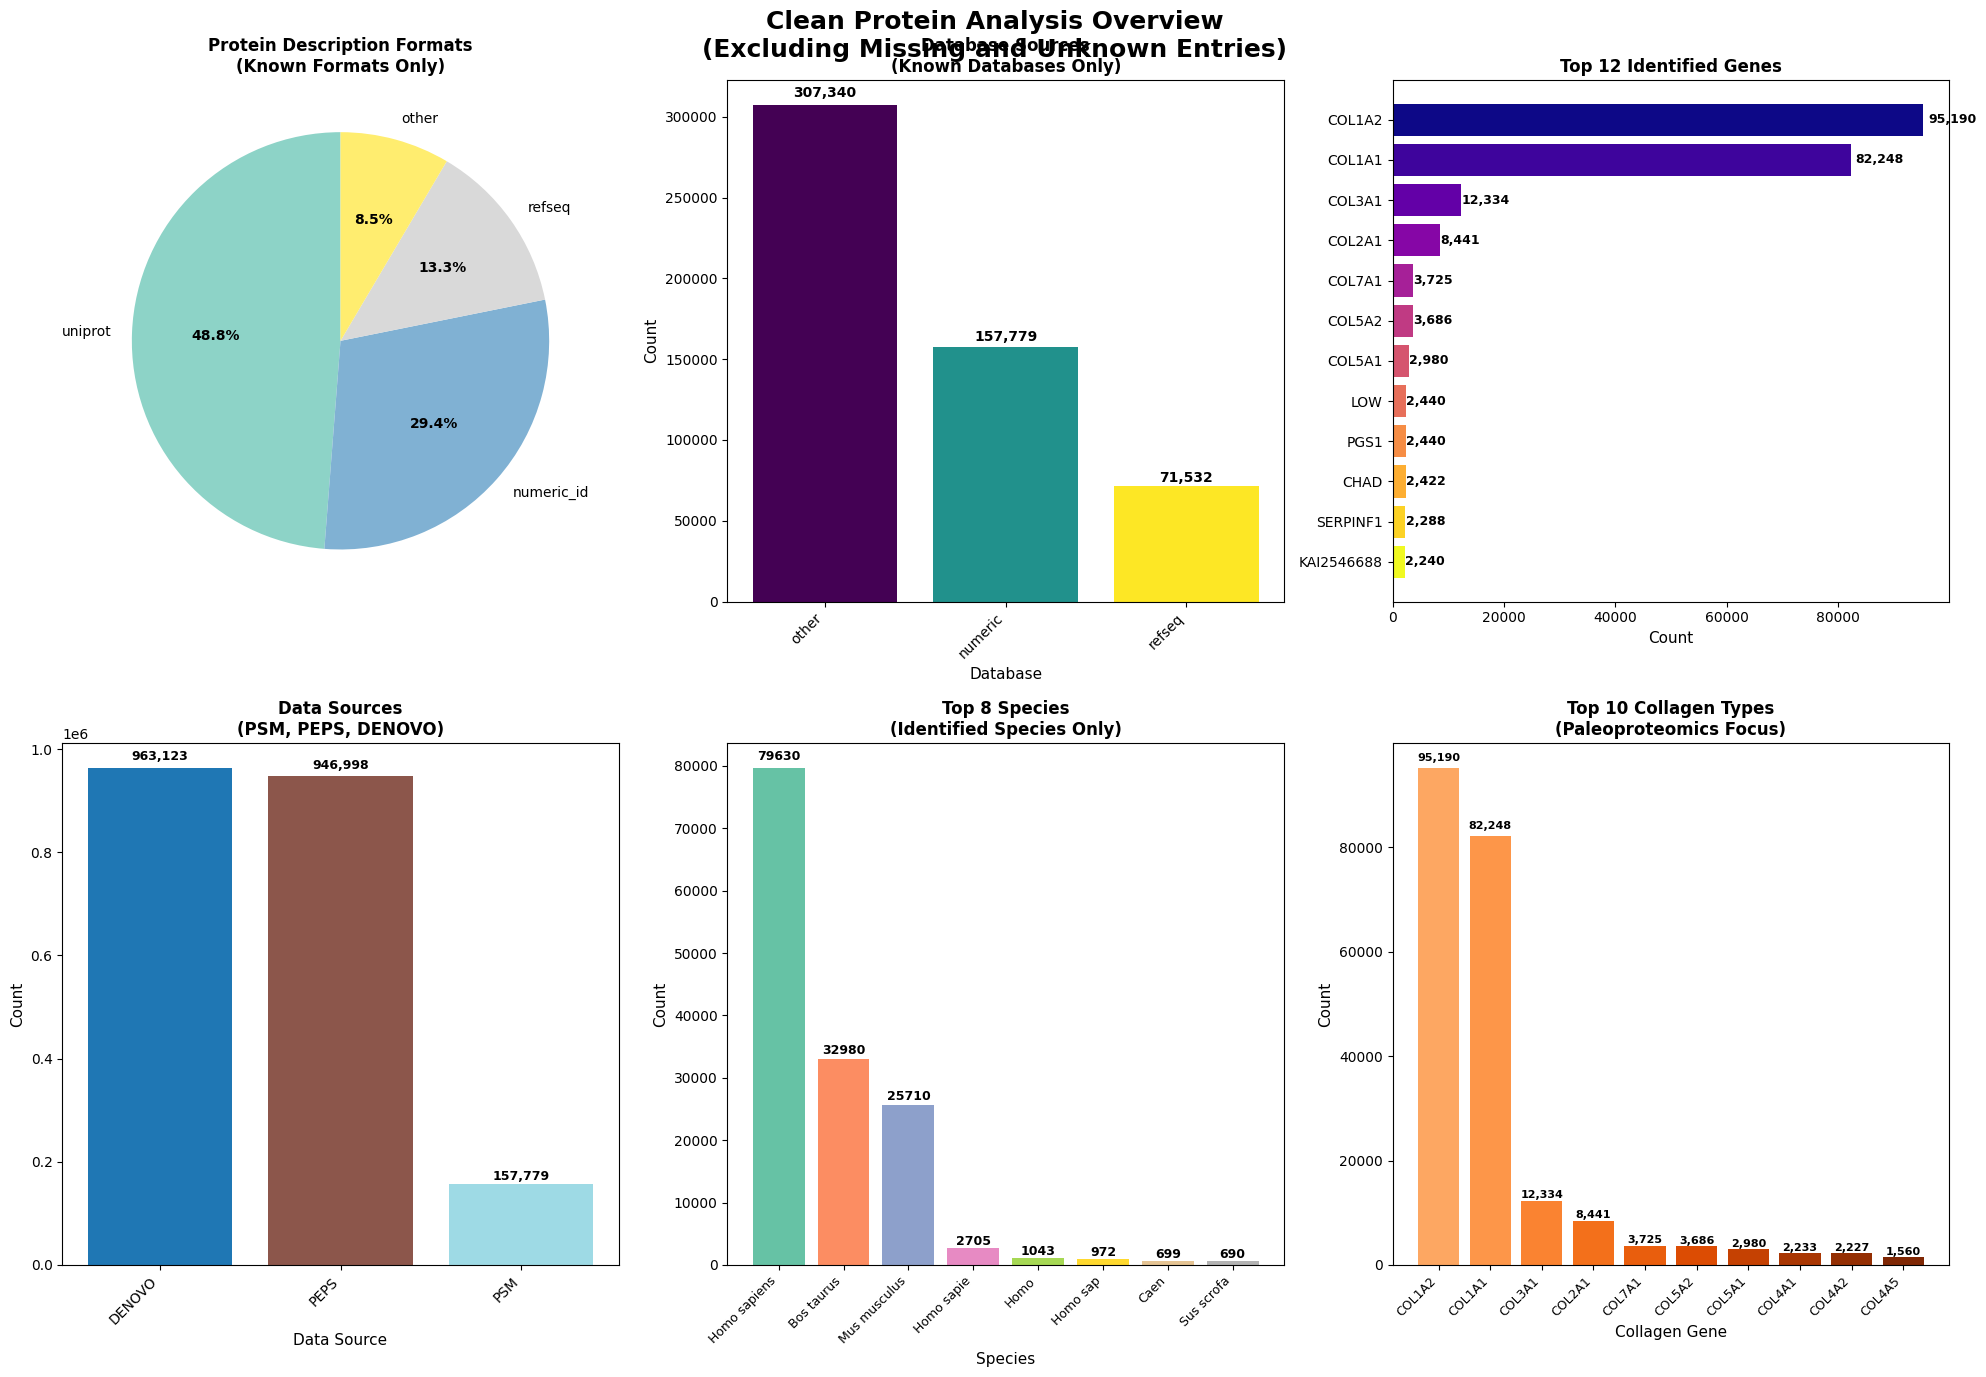


CLEAN ANALYSIS SUMMARY
📊 Format Analysis:
   Entries with known formats: 536,651/2,067,900 (26.0%)
   Most common format: uniprot

📊 Database Analysis:
   Entries with known databases: 536,651/2,067,900 (26.0%)
   Primary database: other

📊 Gene Analysis:
   Entries with identified genes: 361,253/2,067,900 (17.5%)
   Unique genes identified: 5,649
   Most abundant gene: COL1A2 (95,190 entries)

📊 Species Analysis:
   Entries with species info: 155,468/2,067,900 (7.5%)
   Unique species: 342
   Most represented species: Homo sapiens

📊 Collagen Analysis (Paleoproteomics Focus):
   Collagen identifications: 235,042/2,067,900 (11.4%)
   Collagen types identified: 60
   Most abundant collagen: COL1A2 (95,190 entries)

✅ Clean visualization complete - all missing and unknown entries excluded!


In [5]:
# ===== Cell 4 : Protein Analysis Visualization =====
# Creates enhanced visualizations excluding missing and unknown entries
# Provides cleaner view of actual identified proteins and patterns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("CLEAN PROTEIN ANALYSIS VISUALIZATION")
print("(Excluding missing and unknown entries)")
print("=" * 50)

# Use any available enhanced dataframe
try:
    if 'enhanced_df_complete' in globals():
        df = enhanced_df_complete
        source_name = "enhanced_df_complete"
    elif 'enhanced_df' in globals():
        df = enhanced_df
        source_name = "enhanced_df"
    elif 'comprehensive_df' in globals():
        df = comprehensive_df
        source_name = "comprehensive_df"
    elif 'protein_analysis_comprehensive' in globals():
        df = protein_analysis_comprehensive
        source_name = "protein_analysis_comprehensive"
    else:
        raise NameError("No dataframe found")

    print(f"✅ Using dataframe: {source_name}")
    print(f"   Total rows: {len(df):,}")

    # Check available columns
    available_cols = df.columns.tolist()
    print(f"   Available columns include: {len(available_cols)} total")
    if 'consolidated_gene_name' in available_cols:
        print("   ✅ Has consolidated gene names")
    if 'protein' in available_cols:
        print("   ✅ Has protein descriptions")

except NameError:
    print("❌ No dataframe found. Please run Cell 2 and Cell 3 first.")
    df = None

if df is not None and 'protein' in df.columns:

    # Create protein format classification on the fly if not available
    def classify_protein_format(protein_desc):
        """Classify protein description format"""
        if pd.isna(protein_desc) or protein_desc == '':
            return 'empty'

        protein_str = str(protein_desc).strip()

        # UniProt format
        if re.search(r'(sp|tr)\|[A-Z0-9]+\|[A-Z0-9_]+', protein_str):
            return 'uniprot'

        # RefSeq format
        if re.search(r'>?[A-Z]{2}_\d+\.\d+', protein_str):
            return 'refseq'

        # Numeric ID
        if protein_str.isdigit():
            return 'numeric_id'

        return 'other'

    # Create species extraction on the fly if not available
    def extract_species_from_protein(protein_desc):
        """Extract species information from protein description"""
        if pd.isna(protein_desc):
            return None

        protein_str = str(protein_desc)

        # Look for OS= pattern (UniProt)
        os_match = re.search(r'OS=([^=]+?)(?:\s+OX=|\s+GN=|$)', protein_str)
        if os_match:
            return os_match.group(1).strip()

        # Look for species in brackets (RefSeq)
        bracket_match = re.search(r'\[([^\]]+)\]', protein_str)
        if bracket_match:
            return bracket_match.group(1).strip()

        # Look for common species patterns
        if re.search(r'HUMAN', protein_str):
            return 'Homo sapiens'
        elif re.search(r'MOUSE', protein_str):
            return 'Mus musculus'
        elif re.search(r'BOVIN', protein_str):
            return 'Bos taurus'

        return None

    # Create database classification on the fly if not available
    def extract_database(protein_desc):
        """Extract database source from protein description"""
        if pd.isna(protein_desc):
            return 'unknown'

        protein_str = str(protein_desc).strip()

        if re.search(r'^(sp|tr)\|', protein_str):
            return protein_str[:2]  # 'sp' or 'tr'
        elif re.search(r'^>?[A-Z]{2}_\d+\.\d+', protein_str):
            return 'refseq'
        elif protein_str.isdigit():
            return 'numeric'
        else:
            return 'other'

    # Enhanced gene extraction function (from successful diagnostic)
    def extract_gene_on_fly(protein_desc):
        """Enhanced gene extraction function"""
        if pd.isna(protein_desc):
            return None

        protein_str = str(protein_desc)

        # UniProt format
        import re
        uniprot_match = re.search(r'(?:sp|tr)\|[A-Z0-9]+\|([A-Z0-9]+)_', protein_str)
        if uniprot_match:
            gene_candidate = uniprot_match.group(1)
            # Clean up common suffixes
            gene_candidate = re.sub(r'_HUMAN|_MOUSE|_BOVIN|_PIG|_SHEEP', '', gene_candidate)
            return gene_candidate.upper()

        # Collagen patterns
        col_match = re.search(r'collagen\s+alpha-?(\d+)\s*\(([IVX]+)\)', protein_str, re.IGNORECASE)
        if col_match:
            alpha_num = col_match.group(1)
            col_type = col_match.group(2)
            roman_to_num = {'I': '1', 'II': '2', 'III': '3', 'IV': '4', 'V': '5',
                           'VI': '6', 'VII': '7', 'VIII': '8', 'IX': '9', 'X': '10',
                           'XI': '11', 'XII': '12', 'XIII': '13', 'XIV': '14', 'XV': '15'}
            col_num = roman_to_num.get(col_type, col_type)
            return f"COL{col_num}A{alpha_num}"

        # Other common proteins
        if re.search(r'titin', protein_str, re.IGNORECASE):
            return 'TTN'
        if re.search(r'fibronectin', protein_str, re.IGNORECASE):
            return 'FN1'

        return None

    # Prepare clean datasets (exclude missing/unknown)
    print("Preparing clean datasets...")

    # 1. Protein formats
    if 'protein_format' not in df.columns:
        df_temp = df.copy()
        df_temp['protein_format'] = df_temp['protein'].apply(classify_protein_format)
    else:
        df_temp = df.copy()

    format_data = df_temp[df_temp['protein_format'] != 'empty']['protein_format']

    # 2. Database sources
    if 'protein_database' not in df.columns:
        df_temp['protein_database'] = df_temp['protein'].apply(extract_database)

    database_data = df_temp[(df_temp['protein_database'].notna()) &
                           (df_temp['protein_database'] != 'unknown')]['protein_database']

    # 3. Gene names - use the best available source or extract on the fly
    gene_col = None
    clean_genes = None

    # Try to find existing gene columns first
    for potential_col in ['consolidated_gene_name', 'extracted_gene_name', 'gene_name']:
        if potential_col in df.columns:
            temp_genes = df_temp[(df_temp[potential_col].notna()) & (df_temp[potential_col] != "Unknown")][potential_col]
            if len(temp_genes) > 100:  # Only use if we have decent coverage
                gene_col = potential_col
                clean_genes = temp_genes
                break

    # If no good existing gene column, extract on the fly
    if clean_genes is None or len(clean_genes) < 100:
        print("  Extracting genes on the fly for better coverage...")
        df_temp['genes_extracted_live'] = df_temp['protein'].apply(extract_gene_on_fly)
        clean_genes = df_temp[df_temp['genes_extracted_live'].notna()]['genes_extracted_live']
        gene_col = 'genes_extracted_live'

    # 4. Species data
    if 'species_extracted' not in df.columns:
        df_temp['species_extracted'] = df_temp['protein'].apply(extract_species_from_protein)

    clean_species = df_temp[df_temp['species_extracted'].notna()]['species_extracted']

    # 5. Collagen data
    if clean_genes is not None and len(clean_genes) > 0:
        clean_collagen = clean_genes[clean_genes.str.contains('COL', case=False, na=False)]
    else:
        clean_collagen = None

    # 6. Data source analysis
    data_source_data = None
    if 'data_source' in df.columns:
        data_source_data = df_temp['data_source']

    # Create enhanced visualizations
    print("Creating clean visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")  # Use a colorful palette

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('Clean Protein Analysis Overview\n(Excluding Missing and Unknown Entries)',
                 fontsize=18, fontweight='bold', y=0.98)

    # Plot 1: Clean protein formats
    ax1 = axes[0, 0]
    if format_data is not None and len(format_data) > 0:
        format_counts = format_data.value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(format_counts)))
        wedges, texts, autotexts = ax1.pie(format_counts.values, labels=format_counts.index,
                                          autopct='%1.1f%%', colors=colors, startangle=90)
        ax1.set_title('Protein Description Formats\n(Known Formats Only)', fontsize=12, fontweight='bold')
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_fontweight('bold')
    else:
        ax1.text(0.5, 0.5, 'No format data available',
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
        ax1.set_title('Protein Description Formats')

    # Plot 2: Clean database sources
    ax2 = axes[0, 1]
    if database_data is not None and len(database_data) > 0:
        db_counts = database_data.value_counts()
        bars = ax2.bar(range(len(db_counts)), db_counts.values,
                      color=plt.cm.viridis(np.linspace(0, 1, len(db_counts))))
        ax2.set_xticks(range(len(db_counts)))
        ax2.set_xticklabels(db_counts.index, rotation=45, ha='right')
        ax2.set_title('Database Sources\n(Known Databases Only)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Count', fontsize=11)
        ax2.set_xlabel('Database', fontsize=11)

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No database data available',
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Database Sources')

    # Plot 3: Top identified genes
    ax3 = axes[0, 2]
    if clean_genes is not None and len(clean_genes) > 0:
        gene_counts = clean_genes.value_counts().head(12)
        bars = ax3.barh(range(len(gene_counts)), gene_counts.values,
                       color=plt.cm.plasma(np.linspace(0, 1, len(gene_counts))))
        ax3.set_yticks(range(len(gene_counts)))
        ax3.set_yticklabels(gene_counts.index, fontsize=10)
        ax3.set_title('Top 12 Identified Genes', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Count', fontsize=11)
        ax3.invert_yaxis()

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax3.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
                    f'{int(width):,}', ha='left', va='center', fontweight='bold', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'No gene data available',
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Top Identified Genes')

    # Plot 4: Data sources (if available) or protein families
    ax4 = axes[1, 0]
    if data_source_data is not None and len(data_source_data) > 0:
        source_counts = data_source_data.value_counts()
        bars = ax4.bar(range(len(source_counts)), source_counts.values,
                      color=plt.cm.tab20(np.linspace(0, 1, len(source_counts))))
        ax4.set_xticks(range(len(source_counts)))
        ax4.set_xticklabels(source_counts.index, rotation=45, ha='right', fontsize=10)
        ax4.set_title('Data Sources\n(PSM, PEPS, DENOVO)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Count', fontsize=11)
        ax4.set_xlabel('Data Source', fontsize=11)

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        # Show top protein types based on gene names
        if clean_genes is not None and len(clean_genes) > 0:
            # Create protein type classification
            def classify_protein_type(gene_name):
                if pd.isna(gene_name):
                    return 'Unknown'
                gene_upper = str(gene_name).upper()
                if gene_upper.startswith('COL'):
                    return 'Collagen'
                elif gene_upper in ['TTN', 'TITIN']:
                    return 'Titin'
                elif gene_upper.startswith('FN'):
                    return 'Fibronectin'
                elif gene_upper.startswith('MYH'):
                    return 'Myosin'
                elif gene_upper.startswith('ACT'):
                    return 'Actin'
                elif gene_upper.startswith('KRT'):
                    return 'Keratin'
                else:
                    return 'Other'

            protein_types = clean_genes.apply(classify_protein_type)
            type_counts = protein_types.value_counts().head(8)

            bars = ax4.bar(range(len(type_counts)), type_counts.values,
                          color=plt.cm.Set2(np.linspace(0, 1, len(type_counts))))
            ax4.set_xticks(range(len(type_counts)))
            ax4.set_xticklabels(type_counts.index, rotation=45, ha='right', fontsize=10)
            ax4.set_title('Top 8 Protein Types\n(Based on Gene Names)', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Count', fontsize=11)
            ax4.set_xlabel('Protein Type', fontsize=11)

            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        else:
            ax4.text(0.5, 0.5, 'No protein type data available',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Protein Types')

    # Plot 5: Species distribution
    ax5 = axes[1, 1]
    if clean_species is not None and len(clean_species) > 0:
        species_counts = clean_species.value_counts().head(8)
        bars = ax5.bar(range(len(species_counts)), species_counts.values,
                      color=plt.cm.Set2(np.linspace(0, 1, len(species_counts))))
        ax5.set_xticks(range(len(species_counts)))
        # Truncate long species names
        truncated_labels = [label[:15] + '...' if len(label) > 15 else label
                           for label in species_counts.index]
        ax5.set_xticklabels(truncated_labels, rotation=45, ha='right', fontsize=9)
        ax5.set_title('Top 8 Species\n(Identified Species Only)', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Count', fontsize=11)
        ax5.set_xlabel('Species', fontsize=11)

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        ax5.text(0.5, 0.5, 'No species data available',
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Species Distribution')

    # Plot 6: Collagen types
    ax6 = axes[1, 2]
    if clean_collagen is not None and len(clean_collagen) > 0:
        collagen_counts = clean_collagen.value_counts().head(10)
        bars = ax6.bar(range(len(collagen_counts)), collagen_counts.values,
                      color=plt.cm.Oranges(np.linspace(0.4, 1, len(collagen_counts))))
        ax6.set_xticks(range(len(collagen_counts)))
        ax6.set_xticklabels(collagen_counts.index, rotation=45, ha='right', fontsize=9)
        ax6.set_title('Top 10 Collagen Types\n(Paleoproteomics Focus)', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Count', fontsize=11)
        ax6.set_xlabel('Collagen Gene', fontsize=11)

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    else:
        ax6.text(0.5, 0.5, 'No collagen data available',
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Collagen Types')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

    # Print clean summary statistics
    print(f"\n" + "=" * 60)
    print("CLEAN ANALYSIS SUMMARY")
    print("=" * 60)

    total_entries = len(df)

    if format_data is not None:
        known_formats = len(format_data)
        print(f"📊 Format Analysis:")
        print(f"   Entries with known formats: {known_formats:,}/{total_entries:,} ({known_formats/total_entries*100:.1f}%)")
        print(f"   Most common format: {format_data.value_counts().index[0]}")

    if database_data is not None:
        known_databases = len(database_data)
        print(f"\n📊 Database Analysis:")
        print(f"   Entries with known databases: {known_databases:,}/{total_entries:,} ({known_databases/total_entries*100:.1f}%)")
        print(f"   Primary database: {database_data.value_counts().index[0]}")

    if clean_genes is not None:
        identified_genes = len(clean_genes)
        unique_genes = clean_genes.nunique()
        print(f"\n📊 Gene Analysis:")
        print(f"   Entries with identified genes: {identified_genes:,}/{total_entries:,} ({identified_genes/total_entries*100:.1f}%)")
        print(f"   Unique genes identified: {unique_genes:,}")
        print(f"   Most abundant gene: {clean_genes.value_counts().index[0]} ({clean_genes.value_counts().iloc[0]:,} entries)")

    if clean_species is not None:
        identified_species = len(clean_species)
        unique_species = clean_species.nunique()
        print(f"\n📊 Species Analysis:")
        print(f"   Entries with species info: {identified_species:,}/{total_entries:,} ({identified_species/total_entries*100:.1f}%)")
        print(f"   Unique species: {unique_species:,}")
        print(f"   Most represented species: {clean_species.value_counts().index[0]}")

    if clean_collagen is not None:
        collagen_entries = len(clean_collagen)
        unique_collagen = clean_collagen.nunique()
        print(f"\n📊 Collagen Analysis (Paleoproteomics Focus):")
        print(f"   Collagen identifications: {collagen_entries:,}/{total_entries:,} ({collagen_entries/total_entries*100:.1f}%)")
        print(f"   Collagen types identified: {unique_collagen:,}")
        print(f"   Most abundant collagen: {clean_collagen.value_counts().index[0]} ({clean_collagen.value_counts().iloc[0]:,} entries)")

    print(f"\n✅ Clean visualization complete - all missing and unknown entries excluded!")

else:
    print("❌ No data available for visualization")
    print("Please run the protein analysis cell first.")

#Research Question

The Harbin individual shows evidence of Denisovan lineage through specific amino acid variants identified in its proteome. Is this uspported by the data

Based on Table 1 and supporting MS/MS spectra (Data S5), here are the key sites and their corresponding spectra:

**Denisovan-derived amino acid variants in the Harbin individual:**

1.  **COL1A2 R996K**
    * **Description:** This position shows a Lysine (K) allele in the Harbin individual, which is derived in Denisovans, compared to Arginine (R) in Neanderthals, modern humans, and great apes.
    * **Supporting Spectrum:** MS/MS spectrum covering COL1A2 996K, Source file: 20230424_M768_S1.raw, Scan:27931

2.  **COL18A1 G1033R**
    * **Description:** The Harbin cranium is homozygous derived for Arginine (R) at this position, while other groups like Neanderthals, modern humans, and great apes show Glycine (G).
    * **Supporting Spectrum:** MS/MS spectrum covering COL18A1 1033R, Source file: 20220407_RHY_S813.raw, Scan:39111

3.  **COL26A1 R196G**
    * **Description:** The Harbin cranium is heterozygous for this position, showing both Glycine (G) and Arginine (R) alleles. Denisova 3 is also heterozygous, while other groups are consistently Arginine (R).
    * **Supporting Spectra:**
        * MS/MS spectrum covering COL26A1 196G, Source file: 20230419_23M823_S1.raw, Scan:44181
        * MS/MS spectrum covering COL26A1 196G, Source file: 20220415_RHY_M821.raw, Scan:22043

In addition to these, there is another Denisovan-derived position (COL4A3 R368H). Although it retained the ancestral amino acid variant (R) in the Harbin individual and was covered by 2 peptides and 13 PSMs, it is noted to be a less reliable identification.
* **Supporting Spectrum:** MS/MS spectrum covering COL4A3 368R, Source file: 20230419_23M823_S3.raw, Scan:15181

These specific amino acid variants, especially COL1A2 996K, COL18A1 1033R, and COL26A1 196G, provide the proteomic evidence linking the Harbin individual to the Denisovan population.

In [13]:
# ===== Cell 5 =====
# Random Sample Export for Student Review
# Creates a downloadable sample of the enhanced dataset for local examination

import pandas as pd
import numpy as np
from datetime import datetime

print("RANDOM SAMPLE EXPORT FOR STUDENT REVIEW")
print("=" * 50)

# Parameters for sampling
sample_size = 50  #@param {type:"integer"}
random_seed = 42  #@param {type:"integer"}

# Try to use the enhanced dataframe
try:
    # First try the complete enhanced dataframe
    if 'enhanced_df_complete' in globals():
        df_source = enhanced_df_complete
        source_name = "enhanced_df_complete"
    # Fallback to regular enhanced dataframe
    elif 'enhanced_df' in globals():
        df_source = enhanced_df
        source_name = "enhanced_df"
    # Last resort: comprehensive dataframe
    elif 'comprehensive_df' in globals():
        df_source = comprehensive_df
        source_name = "comprehensive_df"
    else:
        raise NameError("No dataframe found")

    print(f"✅ Using dataframe: {source_name}")
    print(f"   Total rows: {len(df_source):,}")
    print(f"   Total columns: {len(df_source.columns)}")

except NameError:
    print("❌ No enhanced dataframe found. Please run Cell 2 and Cell 3 first.")
    df_source = None

if df_source is not None and len(df_source) > 0:
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Determine actual sample size
    actual_sample_size = min(sample_size, len(df_source))

    # Create random sample
    random_sample = df_source.sample(n=actual_sample_size, random_state=random_seed)

    print(f"\n✅ Created random sample of {actual_sample_size} rows")

    # Generate timestamp for filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"student_sample_dataset_{timestamp}.csv"
    filepath = f"/content/{filename}"

    # Save the sample
    random_sample.to_csv(filepath, index=False)
    print(f"✅ Sample saved to: {filepath}")

    # Display basic information about the sample
    print(f"\n" + "=" * 50)
    print("SAMPLE DATASET INFORMATION")
    print("=" * 50)

    print(f"Filename: {filename}")
    print(f"Rows: {len(random_sample)}")
    print(f"Columns: {len(random_sample.columns)}")
    print(f"File size: ~{len(random_sample) * len(random_sample.columns) * 50 / 1024:.1f} KB (estimated)")

    # Show column names and types
    print(f"\nColumn Information:")
    print(f"{'#':<3} {'Column Name':<25} {'Data Type':<15} {'Non-null Count':<12} {'Sample Value'}")
    print("-" * 80)

    for i, col in enumerate(random_sample.columns, 1):
        dtype = str(random_sample[col].dtype)
        non_null = random_sample[col].notna().sum()

        # Get a sample value (first non-null value)
        sample_val = "NaN"
        non_null_values = random_sample[col].dropna()
        if len(non_null_values) > 0:
            sample_val = str(non_null_values.iloc[0])
            # Truncate long values
            if len(sample_val) > 20:
                sample_val = sample_val[:17] + "..."

        print(f"{i:<3} {col:<25} {dtype:<15} {non_null:<12} {sample_val}")

    # Show data source breakdown if available
    if 'data_source' in random_sample.columns:
        print(f"\nData Source Distribution in Sample:")
        for source, count in random_sample['data_source'].value_counts().items():
            percentage = (count / len(random_sample)) * 100
            print(f"  {source}: {count} rows ({percentage:.1f}%)")

    # Show sample type distribution if available
    sample_cols = [col for col in random_sample.columns if 'sample' in col.lower()]
    if sample_cols:
        main_sample_col = sample_cols[0]  # Use first sample-related column
        print(f"\nSample Distribution ({main_sample_col}):")
        for sample, count in random_sample[main_sample_col].value_counts().head(5).items():
            percentage = (count / len(random_sample)) * 100
            print(f"  {sample}: {count} rows ({percentage:.1f}%)")

    # Show gene distribution if available
    if 'gene_name' in random_sample.columns:
        mapped_genes = (random_sample['gene_name'] != "Unknown").sum()
        print(f"\nGene Mapping in Sample:")
        print(f"  Mapped genes: {mapped_genes}/{len(random_sample)} ({mapped_genes/len(random_sample)*100:.1f}%)")

        # Show top genes in sample
        top_genes = random_sample[random_sample['gene_name'] != "Unknown"]['gene_name'].value_counts().head(3)
        if len(top_genes) > 0:
            print(f"  Top genes in sample:")
            for gene, count in top_genes.items():
                print(f"    {gene}: {count} entries")

    # Display first few rows for preview
    print(f"\n" + "=" * 50)
    print("PREVIEW OF SAMPLE DATA (First 3 rows)")
    print("=" * 50)

    # Select key columns for preview
    preview_cols = []
    priority_cols = ['peptide', 'gene_name', 'protein_name', 'sample_type', 'data_source', 'score']

    # Add priority columns if they exist
    for col in priority_cols:
        if col in random_sample.columns:
            preview_cols.append(col)

    # If we don't have enough preview columns, add some more
    if len(preview_cols) < 6:
        remaining_cols = [col for col in random_sample.columns if col not in preview_cols][:6-len(preview_cols)]
        preview_cols.extend(remaining_cols)

    # Show preview
    if preview_cols:
        preview_data = random_sample[preview_cols].head(3)
        print(preview_data.to_string(index=False))

    # Instructions for students
    print(f"\n" + "=" * 50)
    print("INSTRUCTIONS FOR STUDENTS")
    print("=" * 50)
    print(f"1. Download the file '{filename}' from the Files panel (left sidebar)")
    print(f"2. Open it in Excel, Google Sheets, or any CSV viewer")
    print(f"3. Examine the column structure and data types")
    print(f"4. Look for patterns in the data (modifications, proteins, samples)")
    print(f"5. Use this sample to understand the full dataset structure")
    print(f"\nNote: This is a random sample of {actual_sample_size} rows from {len(df_source):,} total rows")
    print(f"Seed used: {random_seed} (for reproducibility)")

    # Download instructions
    print(f"\n" + "=" * 50)
    print("HOW TO DOWNLOAD IN GOOGLE COLAB")
    print("=" * 50)
    print("Method 1 - Files Panel:")
    print("  1. Click the folder icon (📁) in the left sidebar")
    print("  2. Navigate to /content/")
    print(f"  3. Find '{filename}'")
    print("  4. Right-click and select 'Download'")
    print("\nMethod 2 - Code (run this in a new cell):")
    print(f"  from google.colab import files")
    print(f"  files.download('{filepath}')")

else:
    print("❌ Cannot create sample - no data available")
    print("Please run Cell 2 and Cell 3 first to generate the enhanced dataset.")

RANDOM SAMPLE EXPORT FOR STUDENT REVIEW
✅ Using dataframe: enhanced_df
   Total rows: 2,067,900
   Total columns: 79

✅ Created random sample of 50 rows
✅ Sample saved to: /content/student_sample_dataset_20250711_123849.csv

SAMPLE DATASET INFORMATION
Filename: student_sample_dataset_20250711_123849.csv
Rows: 50
Columns: 79
File size: ~192.9 KB (estimated)

Column Information:
#   Column Name               Data Type       Non-null Count Sample Value
--------------------------------------------------------------------------------
1   id                        object          25           30672
2   spectraId                 object          4            29931
3   scanNum                   int64           50           7536
4   RT                        float64         25           658.8
5   mz                        float64         29           762.726
6   z                         int64           50           2
7   pepMass                   float64         4            1442.7405
8   err  

## Next Steps for Analysis
Now that the data is prepared and explored, you can add additional analysis cells to:

1. **Filter peptides by sample type**:

In [12]:
# ===== Cell 6 =====
# Filter peptides by sample metadata for analysis

# Get unique values for all sample metadata columns
unique_samples = ["all"] + sorted(df['sample'].dropna().unique().tolist())
unique_fractions = ["all"] + sorted(df['fraction'].dropna().unique().tolist())
unique_instruments = ["all"] + sorted(df['instrument'].dropna().unique().tolist())
unique_institutes = ["all"] + sorted(df['institute'].dropna().unique().tolist())
unique_analysts = ["all"] + sorted(df['analyst'].dropna().unique().tolist())

print("Available filter options:")
print(f"  Samples: {unique_samples}")
print(f"  Fractions: {unique_fractions}")
print(f"  Instruments: {unique_instruments}")
print(f"  Institutes: {unique_institutes}")
print(f"  Analysts: {unique_analysts}")

# Create dropdown selectors for each metadata column
sample_filter = "all" #@param ["all", "acid insoluable fraction 1", "acid insoluable fraction 2", "acid soluable fraction 10kD", "acid soluable fraction 3-10kD", "acid soluable fraction 3kD", "ammonium bicarbonate fraction"]
fraction_filter = "all" #@param ["all", "acid insoluable fraction 1", "acid insoluable fraction 2", "acid soluable fraction 10kD", "acid soluable fraction 3-10kD", "acid soluable fraction 3kD", "ammonium bicarbonate fraction"]
instrument_filter = "all" #@param ["all", "480", "Exploris"]
institute_filter = "all" #@param ["all", "Capital Medical University", "University of York"]
analyst_filter = "all" #@param ["all", "Carlota", "Virginia"]

# Apply filters sequentially
filtered_df = df.copy()

if sample_filter != "all":
    filtered_df = filtered_df[filtered_df['sample'] == sample_filter]
    print(f"Filtered by sample '{sample_filter}': {len(filtered_df)} peptides remaining")

if fraction_filter != "all":
    filtered_df = filtered_df[filtered_df['fraction'] == fraction_filter]
    print(f"Filtered by fraction '{fraction_filter}': {len(filtered_df)} peptides remaining")

if instrument_filter != "all":
    filtered_df = filtered_df[filtered_df['instrument'] == instrument_filter]
    print(f"Filtered by instrument '{instrument_filter}': {len(filtered_df)} peptides remaining")

if institute_filter != "all":
    filtered_df = filtered_df[filtered_df['institute'] == institute_filter]
    print(f"Filtered by institute '{institute_filter}': {len(filtered_df)} peptides remaining")

if analyst_filter != "all":
    filtered_df = filtered_df[filtered_df['analyst'] == analyst_filter]
    print(f"Filtered by analyst '{analyst_filter}': {len(filtered_df)} peptides remaining")

# Store the filtered result for use in subsequent analyses
selected_peptides = filtered_df

# Display comprehensive information about the filtered dataset
if len(selected_peptides) > 0:
    print(f"\n{'='*50}")
    print(f"FILTERED DATASET SUMMARY")
    print(f"{'='*50}")
    print(f"Total peptides: {len(selected_peptides):,}")
    print(f"Unique peptides: {selected_peptides['stripped_peptide'].nunique():,}")
    print(f"Unique proteins: {selected_peptides['gene_name'].nunique():,}")
    print(f"Unique accession IDs: {selected_peptides['accession_id'].nunique():,}")

    # Score statistics
    print(f"\nScore statistics:")
    print(f"  Range: {selected_peptides['score'].min():.2f} to {selected_peptides['score'].max():.2f}")
    print(f"  Mean: {selected_peptides['score'].mean():.2f}")
    print(f"  Median: {selected_peptides['score'].median():.2f}")

    # Metadata breakdown of filtered data
    print(f"\nMetadata breakdown of filtered data:")
    print(f"  Samples: {', '.join(selected_peptides['sample'].unique())}")
    print(f"  Fractions: {', '.join(selected_peptides['fraction'].unique())}")
    print(f"  Instruments: {', '.join(selected_peptides['instrument'].unique())}")
    print(f"  Institutes: {', '.join(selected_peptides['institute'].unique())}")
    print(f"  Analysts: {', '.join(selected_peptides['analyst'].unique())}")

    # Database and enzyme information
    if 'db_filename' in selected_peptides.columns:
        print(f"  Databases: {', '.join(selected_peptides['db_filename'].unique())}")

    enzyme_cols = [col for col in selected_peptides.columns if col.startswith('enzyme_')]
    if enzyme_cols:
        active_enzymes = []
        for col in enzyme_cols:
            if selected_peptides[col].any():
                enzyme_name = col.replace('enzyme_', '')
                active_enzymes.append(enzyme_name)
        if active_enzymes:
            print(f"  Enzymes used: {', '.join(active_enzymes)}")

    # Top 5 most abundant proteins in filtered data
    print(f"\nTop 5 proteins by peptide count:")
    top_proteins = (selected_peptides.groupby(['gene_name', 'accession_id'])
                   .size()
                   .reset_index(name='peptide_count')
                   .sort_values('peptide_count', ascending=False)
                   .head(5))

    for i, row in top_proteins.iterrows():
        print(f"  {row['gene_name']} ({row['accession_id']}): {row['peptide_count']} peptides")

else:
    print(f"\n❌ No data found with the selected filters:")
    print(f"   Sample: {sample_filter}")
    print(f"   Fraction: {fraction_filter}")
    print(f"   Instrument: {instrument_filter}")
    print(f"   Institute: {institute_filter}")
    print(f"   Analyst: {analyst_filter}")
    print(f"\nTry selecting 'all' for one or more filters to broaden your search.")

Available filter options:
  Samples: ['all', '20220407_RHY_S813', '20220415_RHY_M768', '20220415_RHY_M812', '20220415_RHY_M813', '20220415_RHY_M821', '20220415_RHY_M822', '20220415_RHY_M823', '20230419_23M136', '20230419_23M138_S1', '20230419_23M813_RE1']
  Fractions: ['all', 'unknown']
  Instruments: ['all', 'unknown']
  Institutes: ['all', 'unknown']
  Analysts: ['all', 'unknown']

FILTERED DATASET SUMMARY
Total peptides: 2,067,900
Unique peptides: 1,172,400
Unique proteins: 119
Unique accession IDs: 10,114

Score statistics:
  Range: -7.75 to 99.30
  Mean: 15.33
  Median: 3.42

Metadata breakdown of filtered data:
  Samples: 20230419_23M813_RE1, 20220415_RHY_M813, 20220415_RHY_M812, 20220415_RHY_M821, 20220415_RHY_M768, 20220407_RHY_S813, 20220415_RHY_M822, 20220415_RHY_M823, 20230419_23M138_S1, 20230419_23M136
  Fractions: unknown
  Instruments: unknown
  Institutes: unknown
  Analysts: unknown

Top 5 proteins by peptide count:
  COL1A1 (P02453): 14529 peptides
  COL1A2 (P08123): 1

2. **Analyze peptide modifications**:

3. **Compare identification efficiency across samples**:

In [21]:
# Step 2: Examine peptides at variant positions (expanded search and precise position check)

# Define the variant positions to investigate
# Format: (Gene, Position, Reference_AA, Variant_AA)
variant_positions_expanded = [
    ('COL1A2', 996, 'R', 'K'), # COL1A2 R996K
    # Add other variants here if you want to search for them across all files
    # ('COL18A1', 1033, 'G', 'R'), # COL18A1 G1033R
    # ('COL26A1', 196, 'R', 'G'), # COL26A1 R196G (Variant G)
    # ('COL26A1', 196, 'R', 'R'), # COL26A1 R196G (Reference R)
    # ('COL4A3', 368, 'R', 'H') # COL4A3 R368H (Reference R)
]

print("Examining peptides spanning specified variant positions across ALL relevant data:")
print("="*80)

# Use the full enhanced_df for this broader search
df_to_search = enhanced_df.copy()
print(f"Searching within the full dataset: {len(df_to_search):,} entries")

# Ensure 'start' and 'length' columns are numeric, coercing errors
if 'start' in df_to_search.columns:
    df_to_search['start_numeric'] = pd.to_numeric(df_to_search['start'], errors='coerce')
else:
    df_to_search['start_numeric'] = np.nan
    print("WARNING: 'start' column not found. Cannot perform precise position check.")

if 'length' in df_to_search.columns:
    df_to_search['length_numeric'] = pd.to_numeric(df_to_search['length'], errors='coerce')
else:
    df_to_search['length_numeric'] = np.nan
    print("WARNING: 'length' column not found. Cannot perform precise position check.")


# Function to find if a peptide spans a specific protein position and get the amino acid at that position
def get_amino_acid_at_position(row, target_position):
    """
    Checks if a peptide spans the target position and returns the amino acid at that position.
    Requires 'start_numeric', 'length_numeric', and 'stripped_peptide' columns.
    """
    if pd.isna(row['start_numeric']) or pd.isna(row['length_numeric']) or pd.isna(row['stripped_peptide']):
        return None

    start_pos = int(row['start_numeric'])
    length = int(row['length_numeric'])
    stripped_peptide = row['stripped_peptide']

    # Calculate the end position of the peptide in the protein sequence
    end_pos = start_pos + length - 1

    # Check if the target position falls within the peptide's range (inclusive)
    if target_position >= start_pos and target_position <= end_pos:
        # Calculate the index of the target position within the stripped peptide sequence
        peptide_index = target_position - start_pos

        # Ensure the calculated index is within the bounds of the stripped peptide string
        if peptide_index >= 0 and peptide_index < len(stripped_peptide):
            return stripped_peptide[peptide_index]
        else:
            # This case should ideally not happen if start/length are correct
            return None
    else:
        return None


# Store matching entries
matching_variant_entries = []

# Iterate through each variant position to search for
for gene, position, ref_aa, var_aa in variant_positions_expanded:
    print(f"\nAnalyzing peptides spanning {gene} position {position}...")

    # Filter initial dataframe by gene name and where start/length data is available
    gene_df = df_to_search[
        (df_to_search['consolidated_gene_name'] == gene) &
        (df_to_search['start_numeric'].notna()) &
        (df_to_search['length_numeric'].notna()) &
        (df_to_search['stripped_peptide'].notna())
    ].copy()

    print(f"  Found {len(gene_df):,} entries for gene {gene} with valid start/length data.")

    if len(gene_df) > 0:
        # Find the amino acid at the target position for each peptide in the filtered dataframe
        gene_df['aa_at_position'] = gene_df.apply(
            lambda row: get_amino_acid_at_position(row, position), axis=1
        )

        # Filter for entries where an amino acid was successfully identified at the target position
        peptides_spanning_position = gene_df[gene_df['aa_at_position'].notna()].copy()

        print(f"  Found {len(peptides_spanning_position):,} peptides spanning position {position} in {gene}.")

        if len(peptides_spanning_position) > 0:
            print(f"\nAmino acids found at position {position} in {gene}:")
            aa_counts = peptides_spanning_position['aa_at_position'].value_counts()
            display(aa_counts)

            # Optional: Display sample of peptides spanning the position
            print("\nSample of peptides spanning this position:")
            display(peptides_spanning_position[['peptide', 'stripped_peptide', 'start', 'length', 'aa_at_position', 'score', 'data_source', 'sample', 'protein']].head())

            # You can further filter peptides_spanning_position by 'aa_at_position'
            # to see entries with the reference or variant amino acid.
            variant_peptides = peptides_spanning_position[peptides_spanning_position['aa_at_position'] == var_aa]
            reference_peptides = peptides_spanning_position[peptides_spanning_position['aa_at_position'] == ref_aa]

            print(f"\nSummary for {gene} position {position} ({ref_aa} > {var_aa}):")
            print(f"  Peptides with {var_aa} (variant): {len(variant_peptides):,}")
            print(f"  Peptides with {ref_aa} (reference): {len(reference_peptides):,}")

            if len(variant_peptides) > 0:
                print(f"  Sample of peptides with {var_aa}:")
                display(variant_peptides[['peptide', 'stripped_peptide', 'start', 'length', 'aa_at_position', 'score', 'data_source', 'sample']].head())

            if len(reference_peptides) > 0:
                print(f"  Sample of peptides with {ref_aa}:")
                display(reference_peptides[['peptide', 'stripped_peptide', 'start', 'length', 'aa_at_position', 'score', 'data_source', 'sample']].head())

            # Append to overall matching entries list
            matching_variant_entries.append(peptides_spanning_position)

        else:
            print(f"  No peptides found spanning position {position} in {gene} with valid start/length data.")

    else:
        print(f"  No entries found for gene {gene} with valid start/length data in the dataset.")


print("\n" + "="*80)
print("Peptide spanning position analysis complete. Review the output above for amino acids found at the specified positions.")

# Combine all found entries into a single dataframe for further analysis if needed
if matching_variant_entries:
    # Ensure consistent columns before concatenating
    all_columns = set()
    for df_item in matching_variant_entries:
        all_columns.update(df_item.columns)

    combined_list = []
    for df_item in matching_variant_entries:
        for col in all_columns:
            if col not in df_item.columns:
                df_item[col] = None
        combined_list.append(df_item)

    all_matching_variants_df = pd.concat(combined_list, ignore_index=True, sort=False)


    print(f"\nCombined all potential matching variant/reference peptides: {len(all_matching_variants_df):,} entries.")
    # Store the combined dataframe
    globals()['potential_variant_peptides_df'] = all_matching_variants_df
    print("✅ Potential variant peptides stored as 'potential_variant_peptides_df' variable.")
else:
    print("\nNo peptides found spanning the specified positions across the dataset with valid start/length data.")
    globals()['potential_variant_peptides_df'] = pd.DataFrame() # Create empty df

Examining peptides spanning specified variant positions across ALL relevant data:
Searching within the full dataset: 2,067,900 entries

Analyzing peptides spanning COL1A2 position 996...
  Found 0 entries for gene COL1A2 with valid start/length data.
  No entries found for gene COL1A2 with valid start/length data in the dataset.

Peptide spanning position analysis complete. Review the output above for amino acids found at the specified positions.

No peptides found spanning the specified positions across the dataset with valid start/length data.
